# Line Fitting with APT

## Imports

In [2]:
from delfi.simulator.BaseSimulator import BaseSimulator
import os

import delfi.distribution as dd
import delfi.generator as dg
import numpy as np
import delfi.inference as infer
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
import copy
from mat4py import loadmat
import logging
import datetime
from scipy.io import savemat
import matplotlib.pyplot as plt
from delfi.utils.viz import samples_nd

## Simulator and Model

In [3]:
def linearNoiseSimulator(x, params, seed=None):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    N = x.shape[0]
#     np.random.seed(123) # no noise in the generation procedure
    y = x * alpha + beta + sigma * np.random.randn(N)
    return y

class linearNoiseModel(BaseSimulator):
    def __init__(self, x, seed = None):

        dim_param = 3
        super().__init__(dim_param=dim_param, seed=seed)
        self.x = x
        self.simulate = linearNoiseSimulator
        
    def gen_single(self, params):

        params = np.asarray(params)
        assert params.ndim == 1, 'params.ndim must be 1'
        hh_seed = self.gen_newseed()
        y = self.simulate(self.x, params, seed=hh_seed)
        return {'y': y.reshape(-1)}

## Generate Data

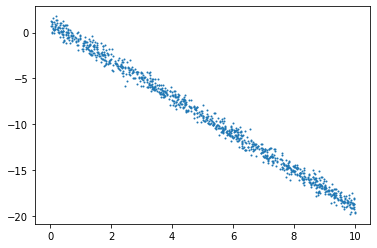

In [4]:
# ground truth of parameters
alpha = -2
beta = 1
sigma = .5
true_params = [alpha,beta,sigma]
labels_params = ['alpha','beta','sigma']
# generate observation
N = 1000
np.random.seed(1234)
x0 = np.random.uniform(0, 10, N)

# define linear noise model
m = linearNoiseModel(x0)

# generate and show observation
obs0 = m.gen_single(true_params)
plt.figure()
plt.scatter(x0,obs0['y'], s=1)

## Summary Statistics

In [14]:
class linearNoiseStats(BaseSummaryStats):
    
    def __init__(self, x):
        self.x = x
        
    def calc(self,repetition_list):
        stats = []
    
        for r in range(len(repetition_list)):
            data = repetition_list[r]
            y = np.asarray(data['y'])
            y_sorted = [yi for xi,yi in sorted(zip(self.x,y))]
            y_sorted = np.array(y_sorted)
            sum_stats_vec = []
            bins = np.linspace(y_sorted[0], y_sorted[-1], 50)
            digitized = np.digitize(y_sorted, bins, 'left')
            bin_means = [y_sorted[digitized == i].mean() for i in range(len(bins))]
            bin_vars = [y_sorted[digitized == i].var() for i in range(len(bins))]
            var = np.mean(bin_vars)
            stats.extend(bin_means)
            stats.extend(bin_vars)
            stats.append(var)
        return [stats]

In [15]:
# define prior
prior_min = np.array([-10,-10,0])
prior_max = np.array([10,10,5])
seed_p = 2
prior =  dd.Uniform(lower = prior_min , upper = prior_max,seed = seed_p)

In [16]:
s = linearNoiseStats(x0)
g = dg.Default(model=m, prior=prior, summary=s)

# define statsitics summary of observation 
obs_stats = s.calc([obs0])

In [17]:
n_train = 2000
n_rounds = 4
seed_inf = 1
pilot_samples = 2000

val_frac = 0.05
# network setup
n_hiddens = [50,50]
minibatch = 500
epochs = 100

prior_norm = True

# MAF parameters
density = 'mog'
# n_mades = 5         # number of MADES

# inference object
res = infer.APT(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                prior_norm=prior_norm,
                density=density)#,
#                n_mades = n_mades)

# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                epochs=epochs,
                silent_fail=False,
                proposal='gaussian',
                val_frac=val_frac,
                verbose=True,)

/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice


Stopping at epoch 83.0, training loss = -4.432655613402388, validation loss = -4.43532585799403




Stopping at epoch 75.0, training loss = -5.370233506182076, validation loss = -5.274621967498301




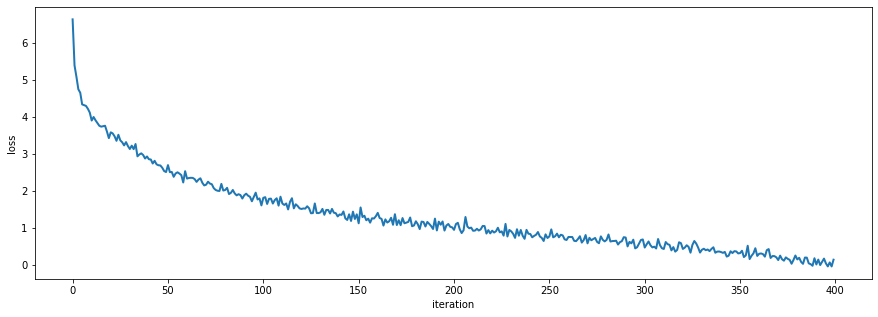

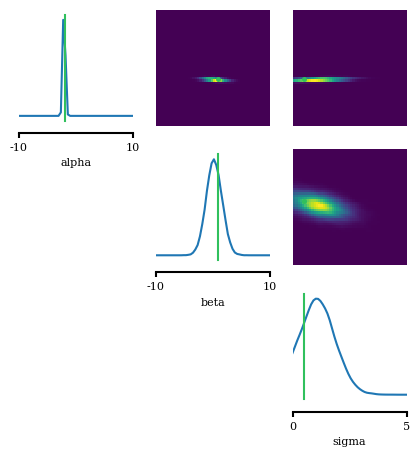

In [19]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

prior_min = g.prior.lower
prior_max = g.prior.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

posterior_samples = posterior[0].gen(10000)

###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

###################
# posterior
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['SNPE']},
                       kde_offdiag={'bins': 50},
                       points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors=[col['GT']],
                       title='');